# 02 — Exploratory Data Analysis: Processed Data

This notebook explores the cleaned and aggregated datasets produced by the processing pipeline:
- Weekly district and section-level time series
- Seasonal patterns and trend analysis
- Waste stream correlations
- Outlier detection
- Spatial distribution overview

**Prerequisites:** Run `make process` first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

import sys
sys.path.insert(0, str(Path.cwd().parent))
from src.config import DATA_PROCESSED, PRIMARY_STREAMS, extract_borough

## 1. Load Processed Data

In [2]:
df_district = pd.read_parquet(DATA_PROCESSED / 'weekly_district.parquet')
df_section = pd.read_parquet(DATA_PROCESSED / 'weekly_section.parquet')

print(f"District-level: {df_district.shape}")
print(f"  Districts: {df_district['District_Code'].nunique()}")
print(f"  Date range: {df_district['week_start'].min()} to {df_district['week_start'].max()}")
print(f"\nSection-level: {df_section.shape}")
print(f"  Sections: {df_section['Section_Code'].nunique()}")

df_district.head()

District-level: (35547, 18)
  Districts: 59
  Date range: 2003-06-30 00:00:00 to 2015-01-19 00:00:00

Section-level: (135429, 18)
  Sections: 232


,District_Code,tons_mgp,tons_paper,tons_refuse,tons_total,week_start,tons_refuse_ma_4wk,tons_paper_ma_4wk,tons_mgp_ma_4wk,tons_total_ma_4wk,tons_refuse_ma_13wk,tons_paper_ma_13wk,tons_mgp_ma_13wk,tons_total_ma_13wk,tons_refuse_ma_52wk,tons_paper_ma_52wk,tons_mgp_ma_52wk,tons_total_ma_52wk
0,BKN01,0.0,8.58,132.64,141.22,2003-06-30,132.640000,8.580000,0.0,141.220000,132.640000,8.580000,0.0,141.220000,132.640000,8.580000,0.0,141.220000
1,BKN01,0.0,10.52,161.98,172.50,2003-07-07,147.310000,9.550000,0.0,156.860000,147.310000,9.550000,0.0,156.860000,147.310000,9.550000,0.0,156.860000
2,BKN01,0.0,12.66,144.93,157.59,2003-07-14,146.516667,10.586667,0.0,157.103333,146.516667,10.586667,0.0,157.103333,146.516667,10.586667,0.0,157.103333
3,BKN01,0.0,16.84,114.58,131.42,2003-07-21,138.532500,12.150000,0.0,150.682500,138.532500,12.150000,0.0,150.682500,138.532500,12.150000,0.0,150.682500
4,BKN01,0.0,9.39,123.08,132.47,2003-07-28,136.142500,12.352500,0.0,148.495000,135.442000,11.598000,0.0,147.040000,135.442000,11.598000,0.0,147.040000


In [3]:
# Summary statistics
print("=== District Weekly Tonnage Stats ===")
for col in ['tons_refuse', 'tons_paper', 'tons_mgp', 'tons_total']:
    print(f"\n{col}:")
    print(df_district[col].describe().round(2))

=== District Weekly Tonnage Stats ===

tons_refuse:
count    35547.00
mean        87.17
std         43.95
min          0.00
25%         54.34
50%         81.93
75%        114.30
max        388.17
Name: tons_refuse, dtype: float64

tons_paper:
count    35547.00
mean        10.26
std          9.54
min          0.00
25%          3.04
50%          8.34
75%         15.08
max        108.00
Name: tons_paper, dtype: float64

tons_mgp:
count    35547.00
mean         6.97
std          6.34
min          0.00
25%          0.87
50%          6.20
75%         10.60
max         76.04
Name: tons_mgp, dtype: float64

tons_total:
count    35547.00
mean       104.39
std         50.37
min          1.53
25%         66.78
50%         98.04
75%        135.48
max        388.17
Name: tons_total, dtype: float64


## 2. Citywide Time Series

<Axes: xlabel='week_start'>

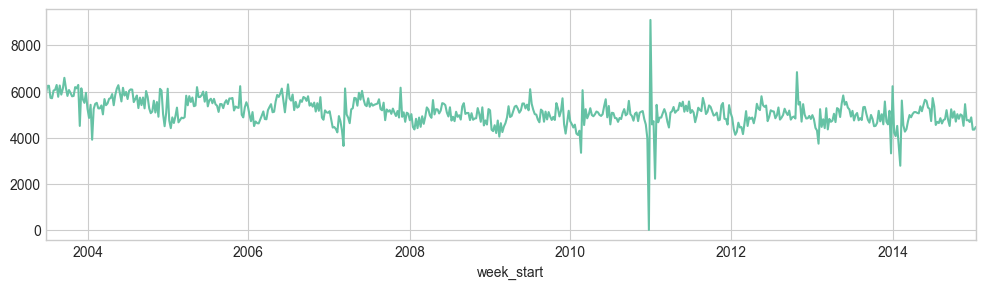

In [19]:
citywide['tons_refuse'].plot(figsize=(12,3))

<Axes: xlabel='week_start'>

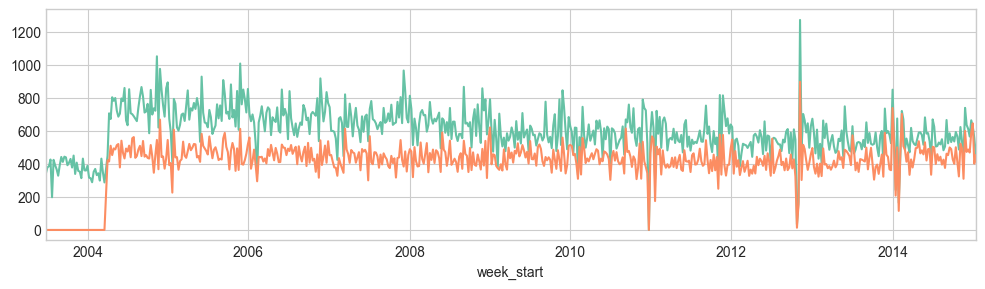

In [20]:
citywide['tons_paper'].plot(figsize=(12,3))
citywide['tons_mgp'].plot(figsize=(12,3))

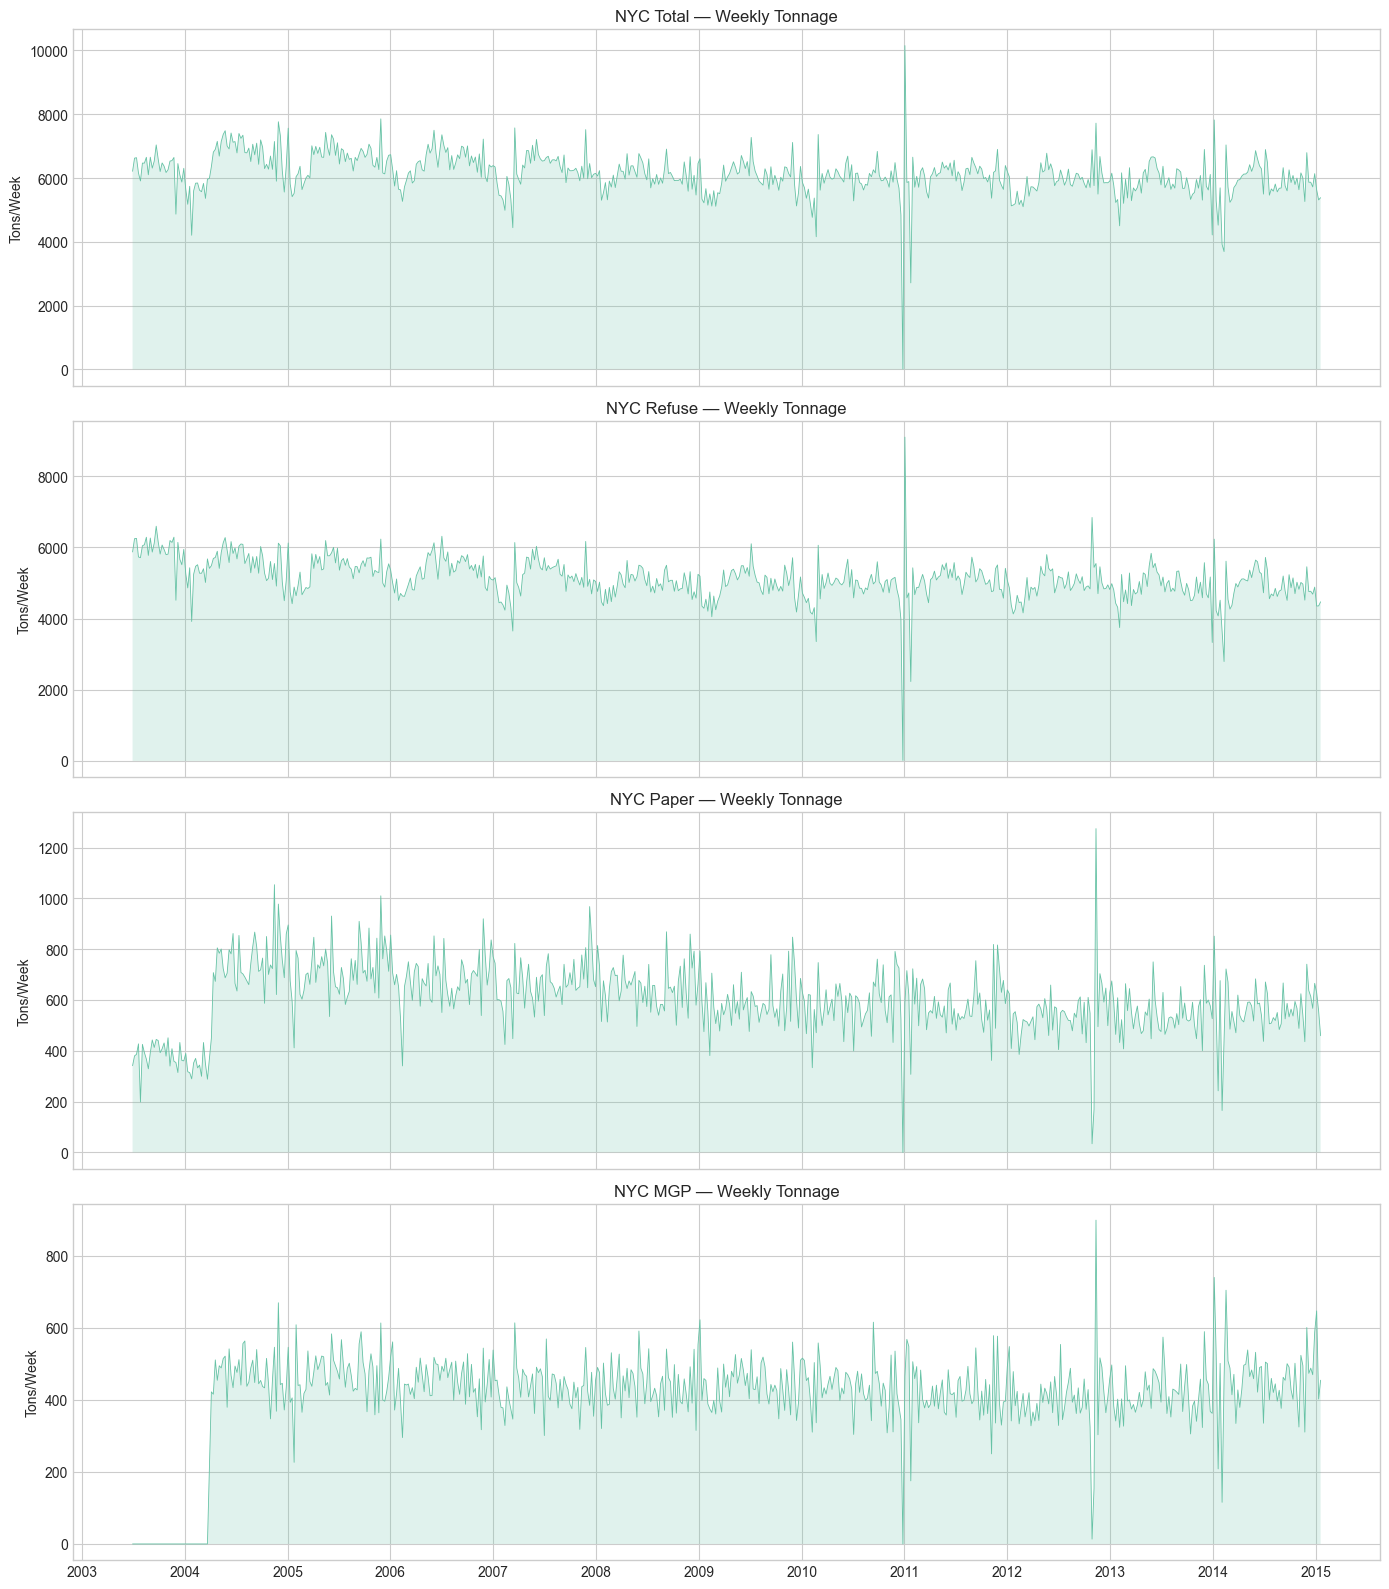

In [4]:
# Aggregate citywide
citywide = df_district.groupby('week_start')[['tons_refuse', 'tons_paper', 'tons_mgp', 'tons_total']].sum()

fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

for ax, (col, label) in zip(axes, [
    ('tons_total', 'Total'),
    ('tons_refuse', 'Refuse'),
    ('tons_paper', 'Paper'),
    ('tons_mgp', 'MGP'),
]):
    ax.plot(citywide.index, citywide[col], linewidth=0.6)
    ax.fill_between(citywide.index, citywide[col], alpha=0.2)
    ax.set_ylabel('Tons/Week')
    ax.set_title(f'NYC {label} — Weekly Tonnage')

axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

## 3. Borough-Level Patterns

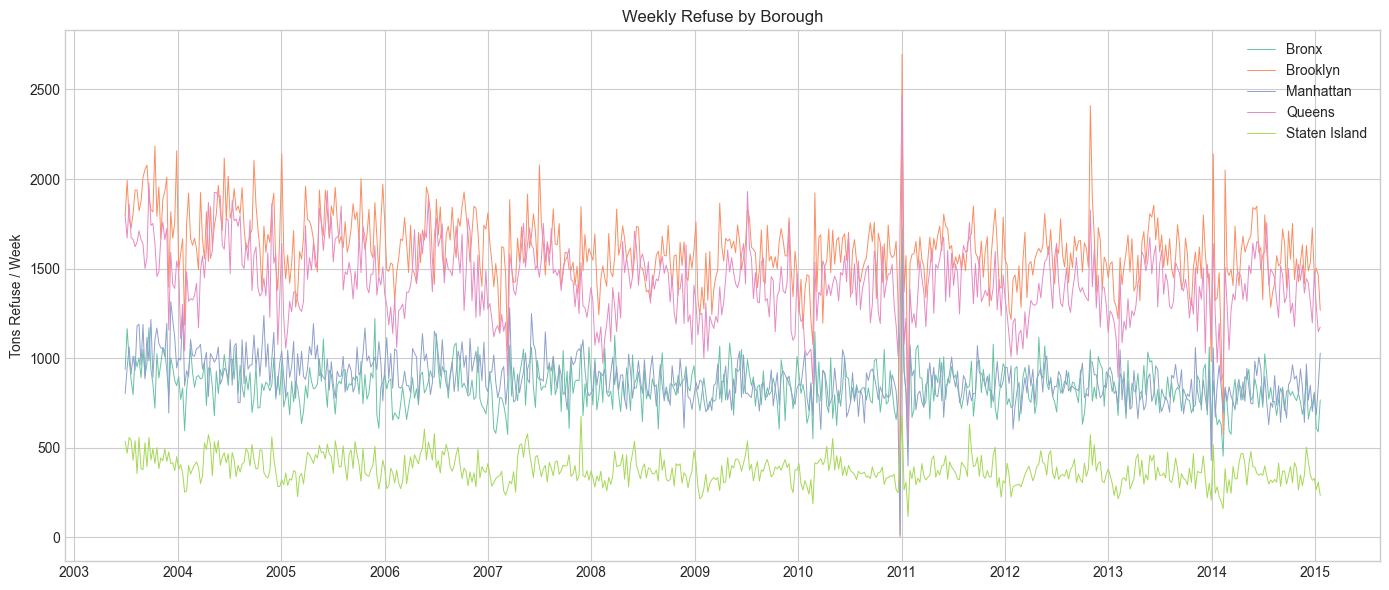

In [5]:
df_district['borough'] = df_district['District_Code'].apply(extract_borough)

borough_weekly = df_district.groupby(['borough', 'week_start'])['tons_refuse'].sum().reset_index()
boroughs = sorted(borough_weekly['borough'].unique())

fig, ax = plt.subplots(figsize=(14, 6))
for borough in boroughs:
    data = borough_weekly[borough_weekly['borough'] == borough]
    ax.plot(data['week_start'], data['tons_refuse'], linewidth=0.7, label=borough)

ax.legend()
ax.set_ylabel('Tons Refuse / Week')
ax.set_title('Weekly Refuse by Borough')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

## 4. Seasonal Patterns

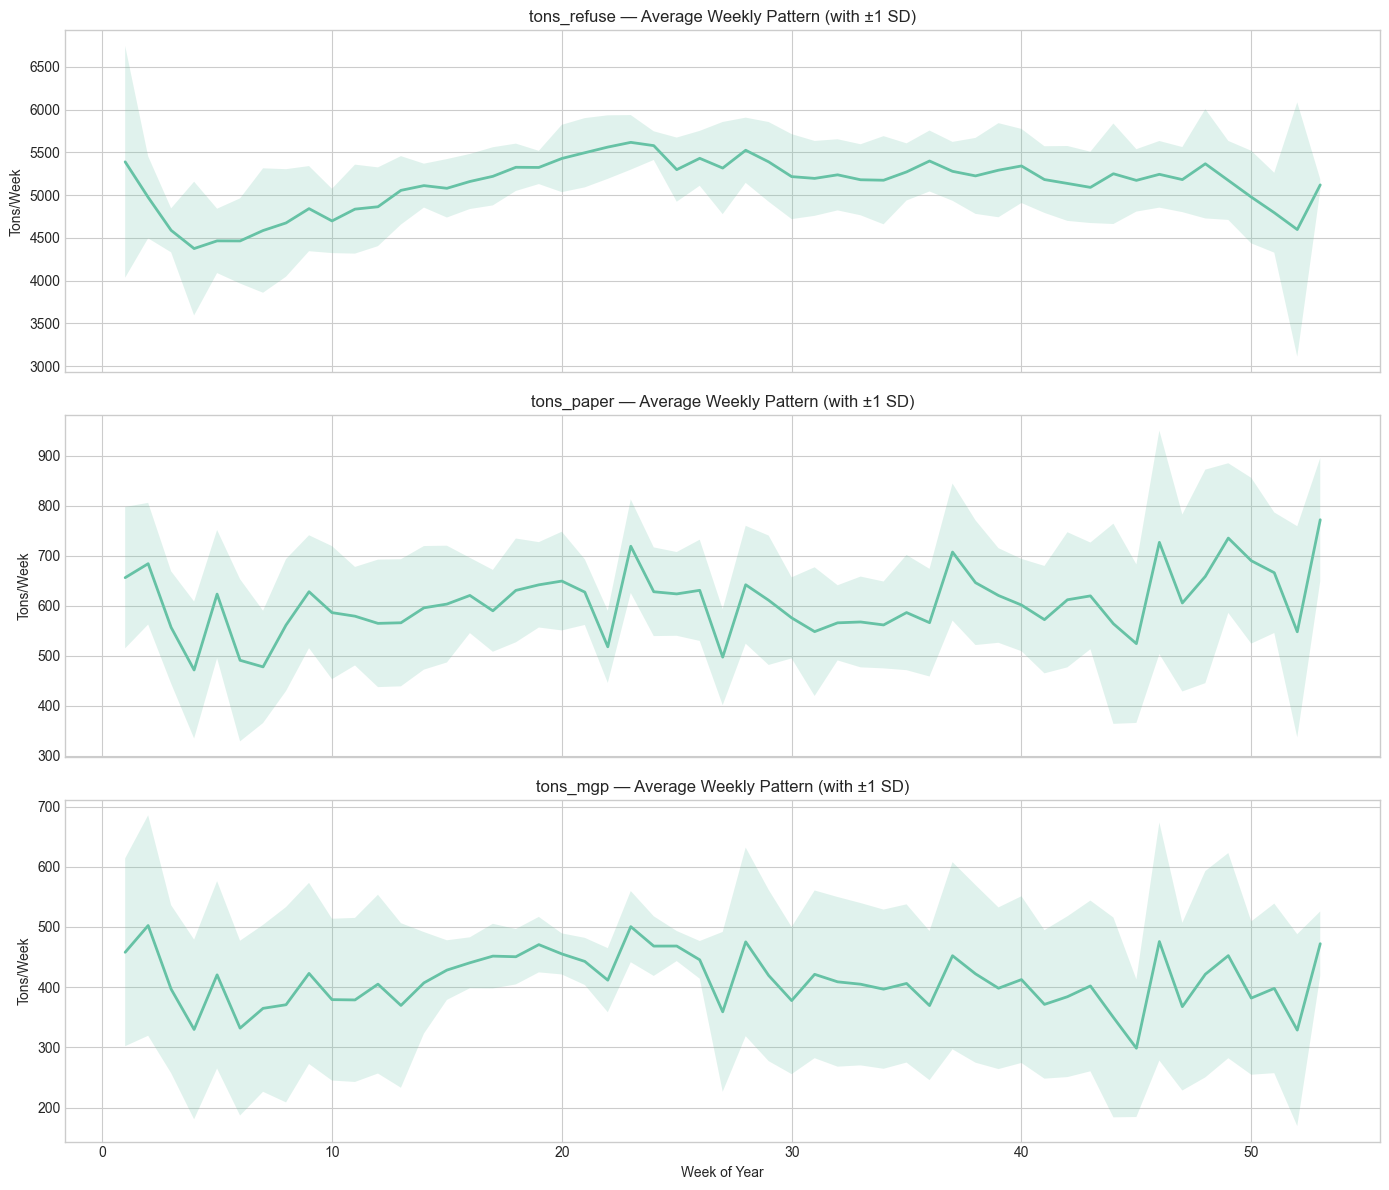

In [6]:
# Average by week of year
citywide_reset = citywide.reset_index()
citywide_reset['week_of_year'] = citywide_reset['week_start'].dt.isocalendar().week.astype(int)

seasonal = citywide_reset.groupby('week_of_year')[['tons_refuse', 'tons_paper', 'tons_mgp']].agg(['mean', 'std'])

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for ax, stream in zip(axes, ['tons_refuse', 'tons_paper', 'tons_mgp']):
    mean = seasonal[(stream, 'mean')]
    std = seasonal[(stream, 'std')]
    ax.plot(mean.index, mean, linewidth=2)
    ax.fill_between(mean.index, mean - std, mean + std, alpha=0.2)
    ax.set_ylabel('Tons/Week')
    ax.set_title(f'{stream} — Average Weekly Pattern (with ±1 SD)')

axes[-1].set_xlabel('Week of Year')
plt.tight_layout()
plt.show()

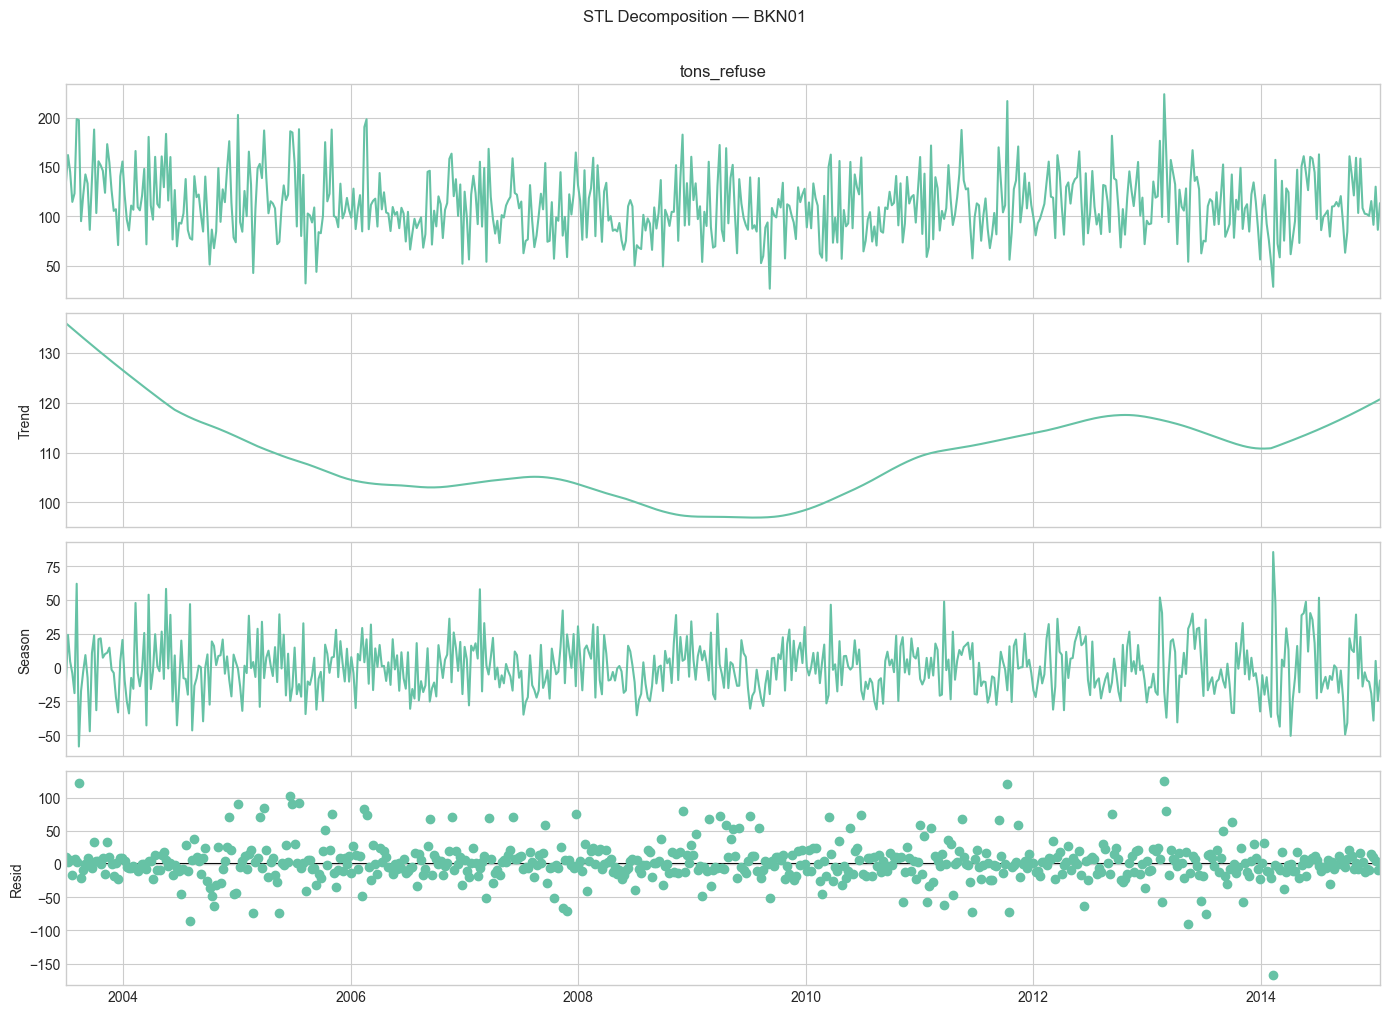

In [7]:
# STL decomposition for a representative district
district_example = df_district['District_Code'].unique()[0]
ts = df_district[df_district['District_Code'] == district_example].set_index('week_start')['tons_refuse']
ts = ts.asfreq('W-MON').interpolate()

stl = STL(ts, period=52, robust=True)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(14, 10)
fig.suptitle(f'STL Decomposition — {district_example}', y=1.01)
plt.tight_layout()
plt.show()

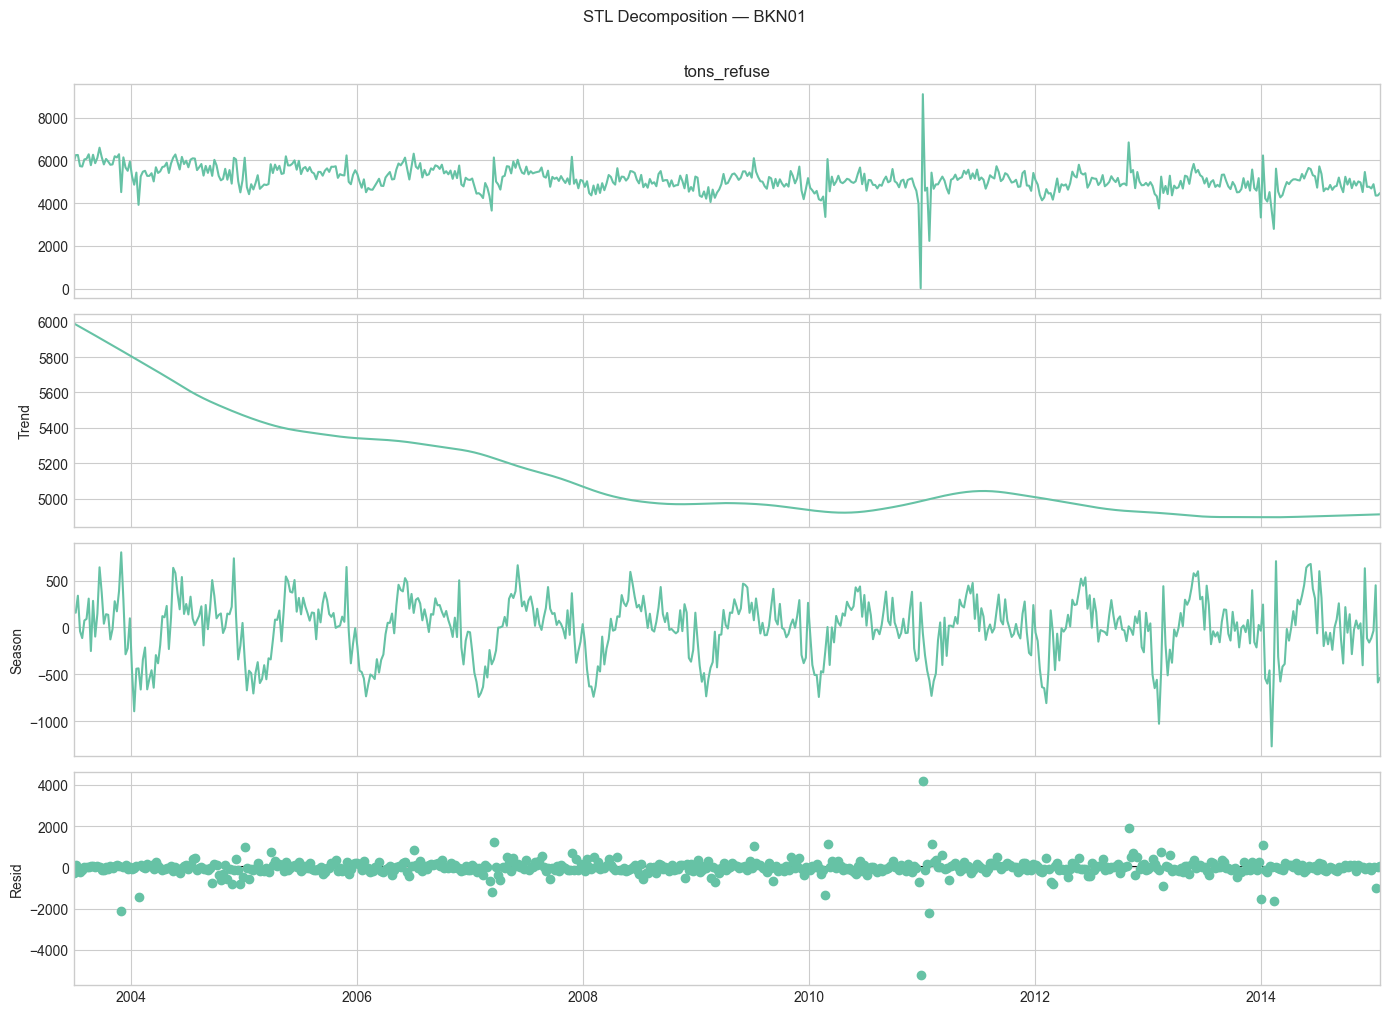

In [25]:
# STL decomposition for a representative district
#district_example = df_district['District_Code'].unique()[0]
#ts = df_district[df_district['District_Code'] == district_example].set_index('week_start')['tons_refuse']
ts = citywide['tons_refuse']  # Use citywide for better seasonality
ts = ts.asfreq('W-MON').interpolate()

stl = STL(ts, period=52, robust=True)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(14, 10)
fig.suptitle(f'STL Decomposition — {district_example}', y=1.01)
plt.tight_layout()
plt.show()

## 5. ACF / PACF

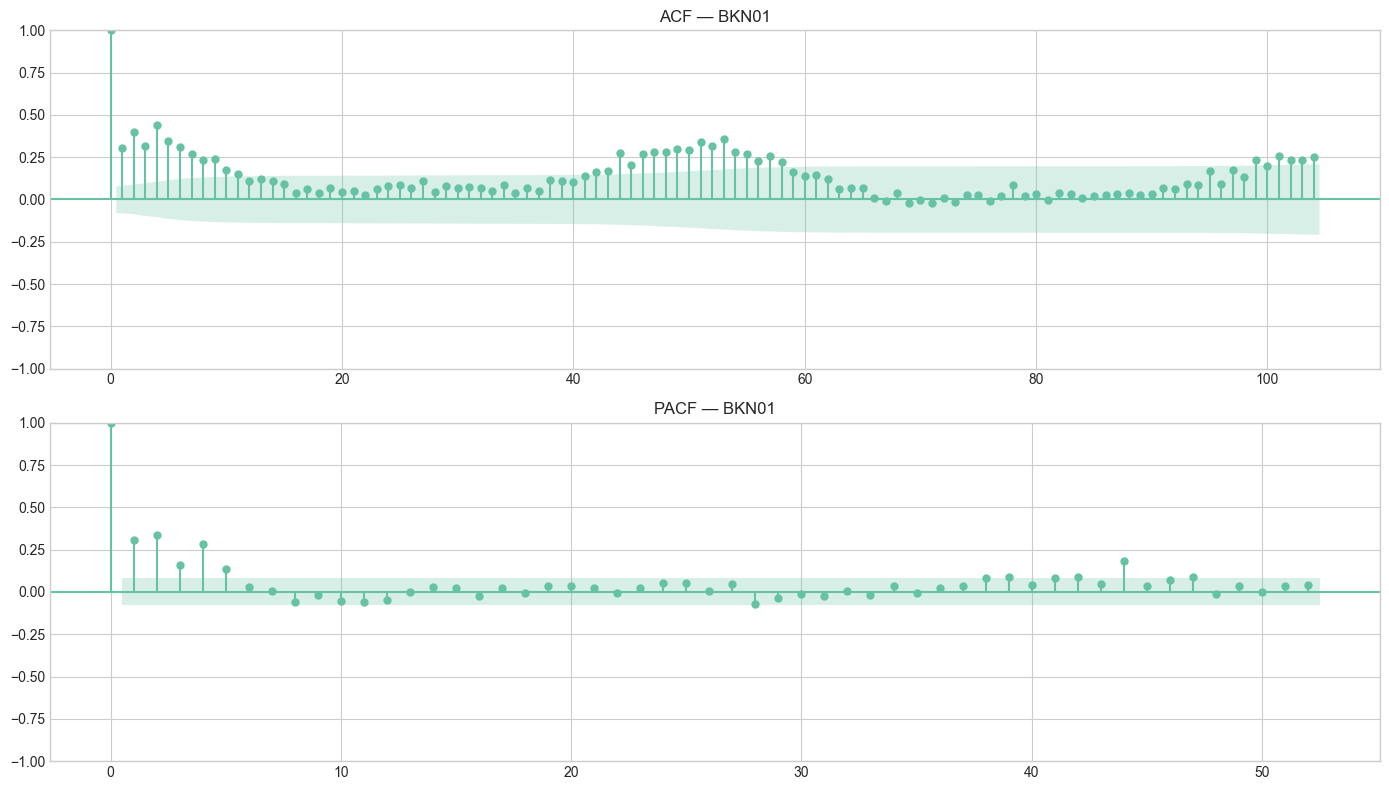

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(ts.dropna(), lags=104, ax=axes[0], title=f'ACF — {district_example}')
plot_pacf(ts.dropna(), lags=52, ax=axes[1], title=f'PACF — {district_example}')
plt.tight_layout()
plt.show()

## 6. Waste Stream Correlations

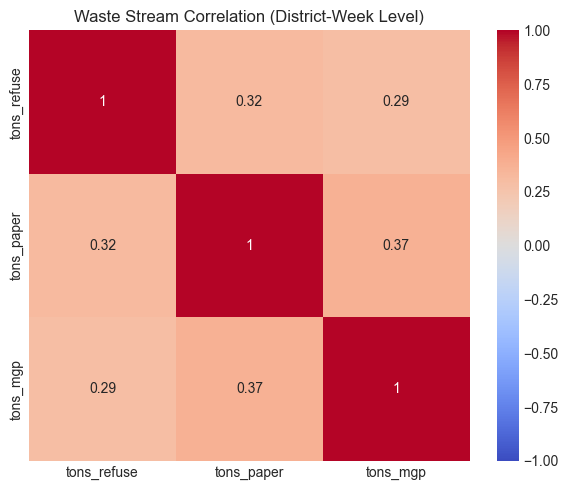

In [9]:
# Correlation between streams at district level
stream_corr = df_district[['tons_refuse', 'tons_paper', 'tons_mgp']].corr()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(stream_corr, annot=True, cmap='coolwarm', center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Waste Stream Correlation (District-Week Level)')
plt.tight_layout()
plt.show()

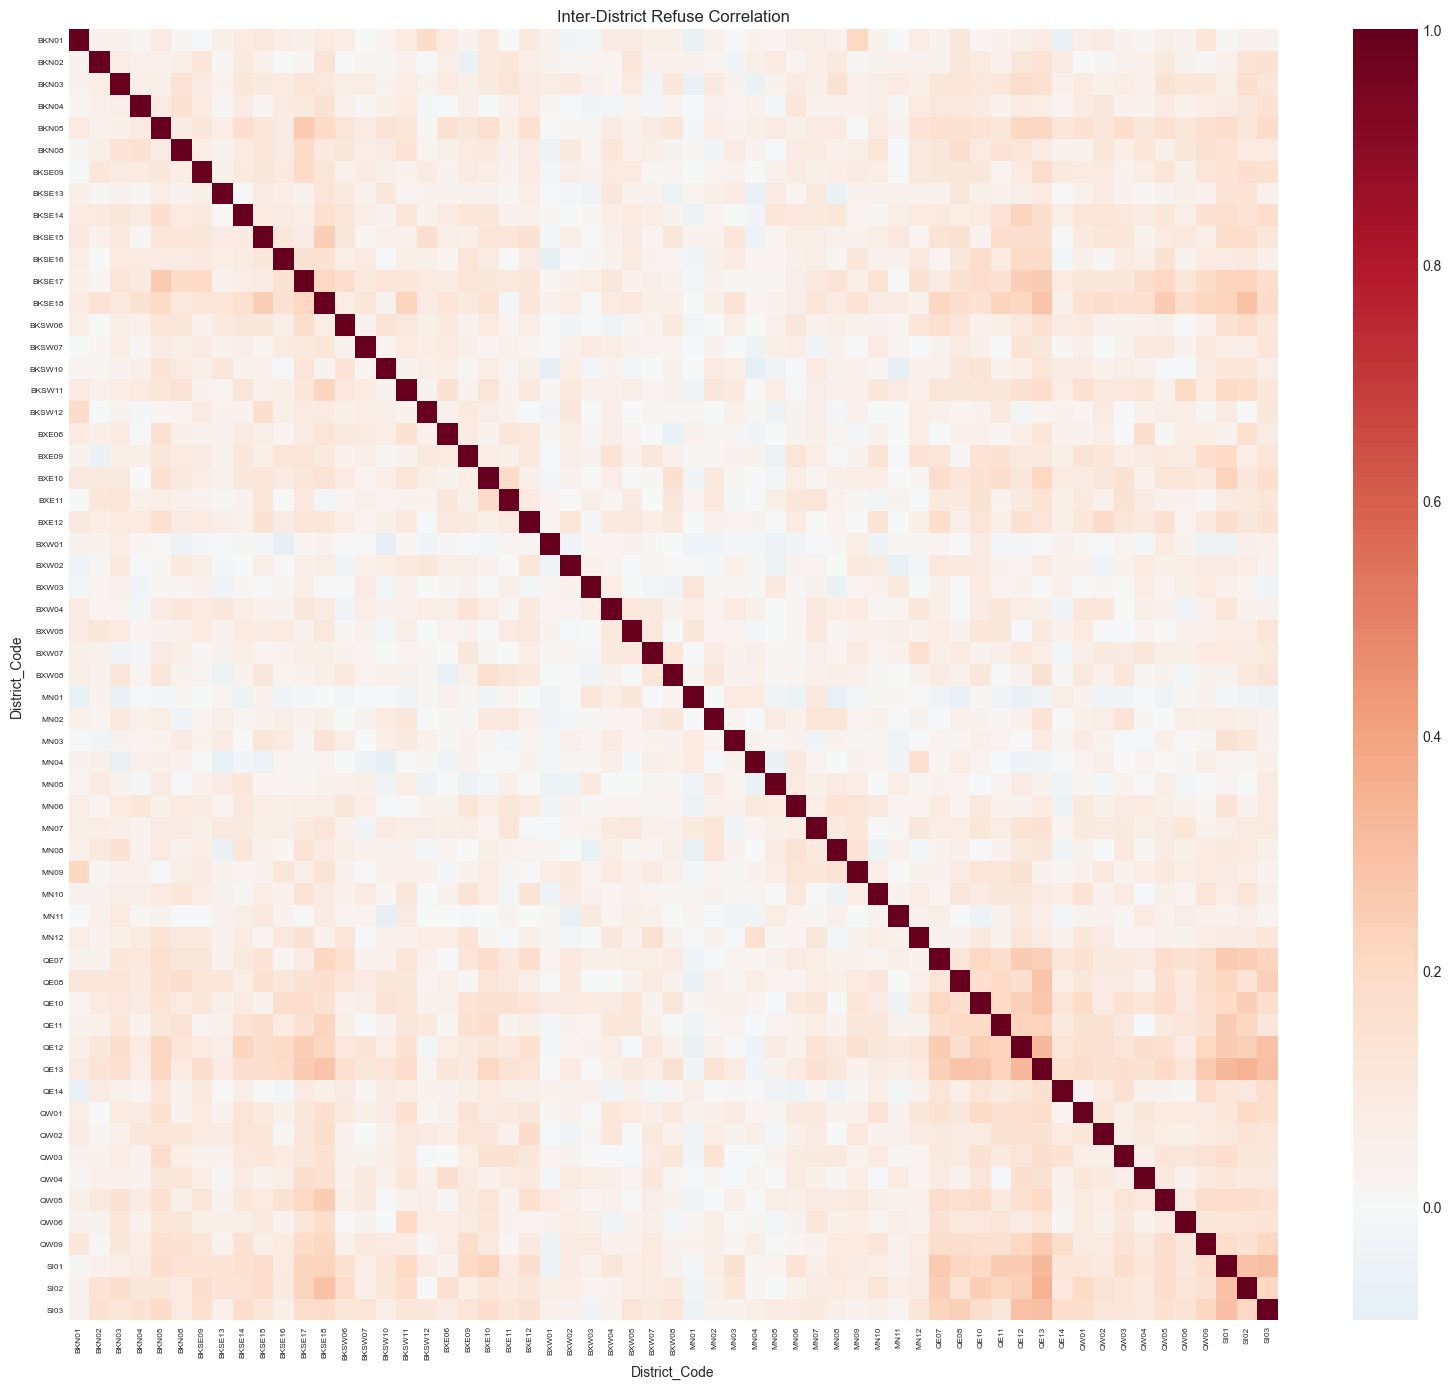

In [10]:
# Cross-district correlation heatmap (refuse)
pivot = df_district.pivot_table(index='week_start', columns='District_Code', values='tons_refuse')
corr = pivot.corr()

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr, cmap='RdBu_r', center=0, ax=ax, xticklabels=True, yticklabels=True)
ax.set_title('Inter-District Refuse Correlation')
plt.xticks(fontsize=6, rotation=90)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

## 7. Outlier Detection

Outlier weeks (|z| > 3): 147 (0.41%)

Outliers by borough:
borough
Brooklyn         53
Manhattan        31
Bronx            29
Queens           27
Staten Island     7
Name: count, dtype: int64


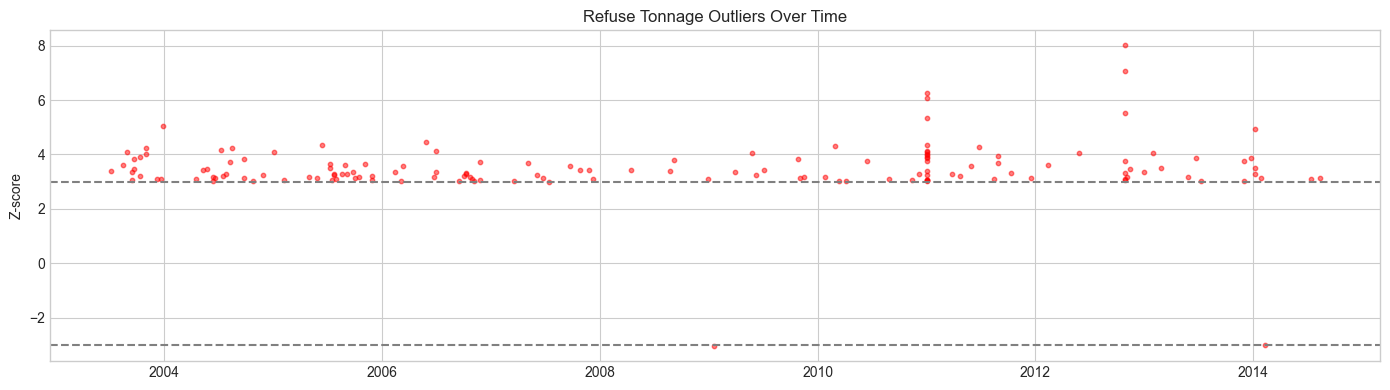

In [11]:
# Z-score outliers per district
df_district['z_refuse'] = df_district.groupby('District_Code')['tons_refuse'].transform(
    lambda x: (x - x.mean()) / x.std()
)

outliers = df_district[abs(df_district['z_refuse']) > 3]
print(f"Outlier weeks (|z| > 3): {len(outliers)} ({len(outliers)/len(df_district):.2%})")
print(f"\nOutliers by borough:")
print(outliers['borough'].value_counts())

# Timeline of outliers
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(outliers['week_start'], outliers['z_refuse'], s=10, alpha=0.5, c='red')
ax.axhline(y=3, color='gray', linestyle='--')
ax.axhline(y=-3, color='gray', linestyle='--')
ax.set_ylabel('Z-score')
ax.set_title('Refuse Tonnage Outliers Over Time')
plt.tight_layout()
plt.show()

## 8. District-Level Variation

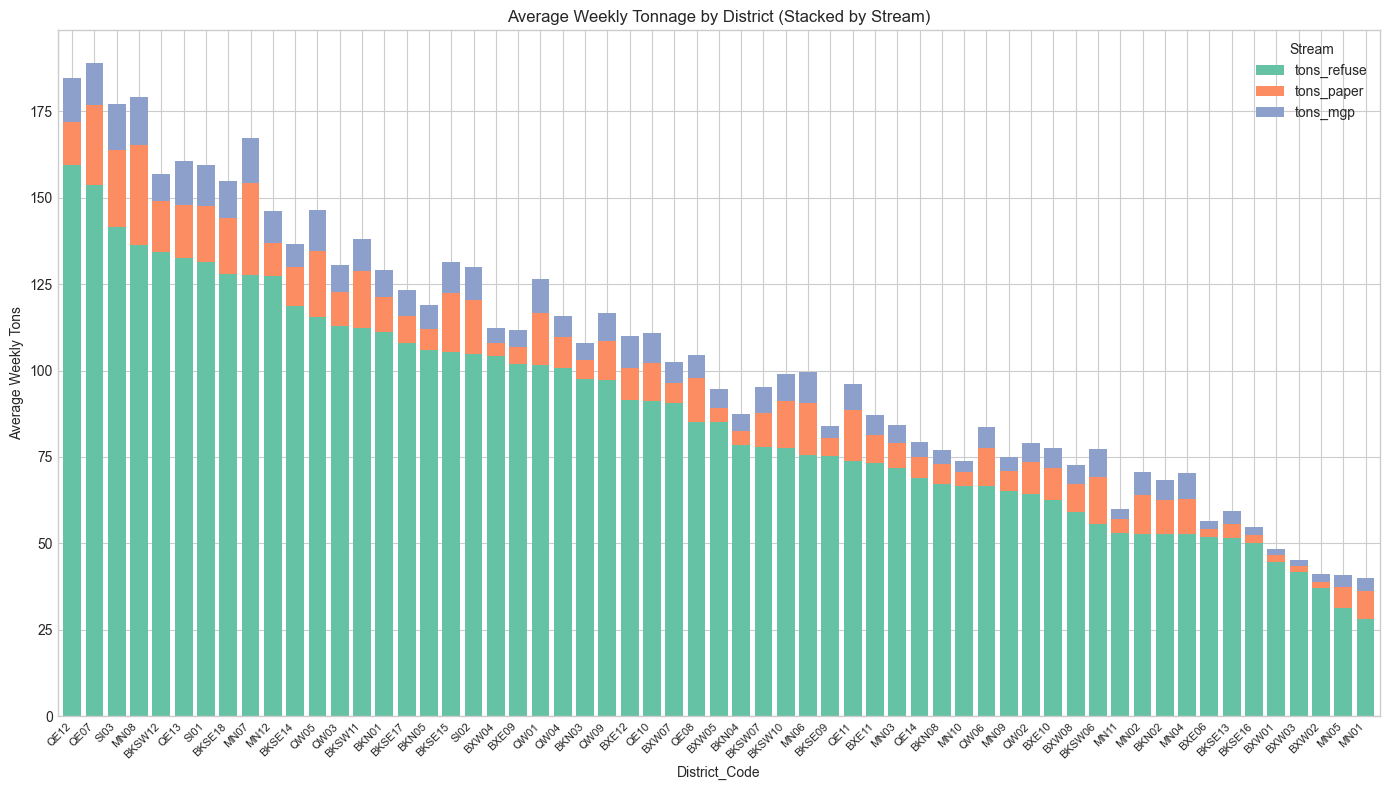

In [12]:
# Average tonnage by district
district_avg = df_district.groupby('District_Code')[['tons_refuse', 'tons_paper', 'tons_mgp']].mean()
district_avg = district_avg.sort_values('tons_refuse', ascending=False)

fig, ax = plt.subplots(figsize=(14, 8))
district_avg.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_ylabel('Average Weekly Tons')
ax.set_title('Average Weekly Tonnage by District (Stacked by Stream)')
ax.legend(title='Stream')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

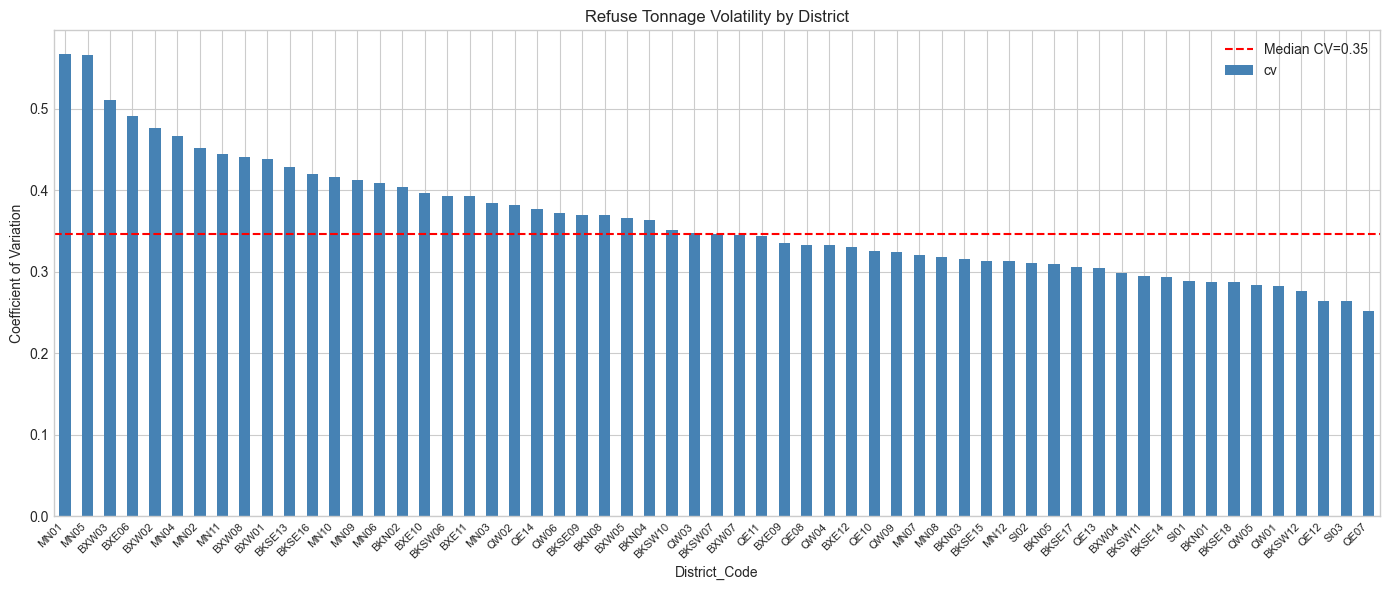

In [13]:
# Coefficient of variation (volatility) by district
cv = df_district.groupby('District_Code')['tons_refuse'].agg(['mean', 'std'])
cv['cv'] = cv['std'] / cv['mean']
cv = cv.sort_values('cv', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
cv['cv'].plot(kind='bar', ax=ax, color='steelblue')
ax.axhline(y=cv['cv'].median(), color='red', linestyle='--', label=f'Median CV={cv["cv"].median():.2f}')
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Refuse Tonnage Volatility by District')
ax.legend()
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()